# Informes y predicciones de COVID-19 en España 

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Pain_Graphs.ipynb).

**Indice**

## [1. Datos de Madrid, hoy](#DatosMadrid)

## 2. Comparativas y predicciones

| Comparativas de dos dimensiones | Comparativas por comunidades  | Comparativas individuales | Predicciones |
| --- | --- | --- |  --- | 
| [Casos Vs fallecidos, historicos](#Comparativa_Casos_Fallecidos) | [Comparativa de fallecidos](#Comunidades_Fallecidos) | [Fallecidos hoy, en España](#Pico_España) | [Predicción de fallecidos, en España](#Prediccion_Fallecidos_España)|
| [Casos Vs fallecidos, hoy](#Comparativa_Casos_Fallecidos_Hoy) |   [Comparativa de fallecidos, hoy](#Comunidades_Fallecidos_Hoy) | [Fallecidos hoy, en Madrid](#Reporte_Fallecidos_hoy_absoluto_Madrid)|  [Predicción de fallecidos, en Madrid](#Prediccion_Fallecidos_hoy_absoluto_Madrid)
| [Casos Vs fallecidos, variación diaria](#Comparativa_Casos_Fallecidos_Variacion_Diaria) |[Comparativa de mortalidad](#Comunidades_Mortalidad)| [Fallecidos hoy, en Cataluña](#Reporte_Fallecidos_hoy_absoluto_Cataluña)|  [Predicción de fallecidos, en Cataluña](#Prediccion_Fallecidos_hoy_absoluto_Cataluña)
|  |  [Comparativa de curados](#Curados)| [Fallecidos hoy, en Castilla y León](#Reporte_Fallecidos_hoy_absoluto_CyL)|[Predicción de fallecidos, en Castilla y León](#Prediccion_Fallecidos_hoy_absoluto_CyL)
|  | | [Fallecidos hoy, en Castilla La Mancha](#Reporte_Fallecidos_hoy_absoluto_CM) |[Predicción de fallecidos, en Castilla La Mancha](#Prediccion_Fallecidos_hoy_absoluto_CM)
|  |  | | |
  



## [3. ¿ Son reales estos datos ?](#Reales)




In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

def Insertar_Enlace(cell_name):
    display(HTML('<a id="'+ cell_name +'"></a>'))

Insertar_Enlace('DatosMadrid')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad.head(10)




,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados hoy absoluto / Casos hoy absoluto,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-05-25,Madrid,67932,61,-200,0.000898,8686,-291,-312,-0.033502,0.127863,0,0.0,67932,0.000000,3536,41872
2020-05-24,Madrid,67871,261,76,0.003846,8977,21,9,0.002339,0.132266,0,0.0,67871,0.000000,3635,42692
2020-05-23,Madrid,67610,185,-191,0.002736,8956,12,-1,0.001340,0.132466,0,0.0,67610,0.000000,3634,42632
2020-05-22,Madrid,67425,376,187,0.005577,8944,13,-6,0.001453,0.132651,0,0.0,67425,0.000000,3627,42573
2020-05-21,Madrid,67049,189,-28,0.002819,8931,19,1,0.002127,0.133201,0,0.0,67049,0.000000,3617,42497
2020-05-20,Madrid,66860,217,-124,0.003246,8912,18,-13,0.002020,0.133293,0,0.0,66860,0.000000,3610,42422
2020-05-19,Madrid,66643,341,377,0.005117,8894,31,15,0.003485,0.133457,0,0.0,66643,0.000000,3600,42350
2020-05-18,Madrid,66302,-36,-164,-0.000543,8863,16,-5,0.001805,0.133676,0,-40698.0,66302,1130.500000,3594,42283
2020-05-17,Madrid,66338,128,-77,0.001930,8847,21,4,0.002374,0.133362,40698,112.0,25640,0.875000,3584,42227


In [2]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos,media_movil ):
    array = []
    dias_a_considerar = 4 if media_movil else 1
    for ca in COMUNIDADES: 
        
        comunidad = Loading_data.Get_Comunidad(ca).head(dias_a_considerar)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        if media_movil : comunidad = pd.DataFrame(comunidad.mean(axis=0)).T 
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [3]:
import scipy.stats as spstats
from matplotlib import pyplot as plt    


def Print_Two_Cordinates_CCAA(df, add_LR=False):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.axhline(y=0, color='blue')
    ax.axvline(x=0, color='blue')

    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    
    if add_LR:
        slope, intercept, r_value, p_value, std_err = spstats.linregress(df[df.columns[1]], df[df.columns[2]])
        plt.plot(df[df.columns[1]], intercept + slope*df[df.columns[1]], 'r', label='fitted line')
        #.format(round(slope, 2),round(intercept, 2),round(r_value, 2))
        note2add = f"""slope: {slope:12.4f}\nintercept: {intercept:8.2f}\nr2: {r_value**2:15.4f}"""
        plt.annotate(note2add,xy=(0.7,0.3), xycoords='figure fraction')
        
    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    
    return plt


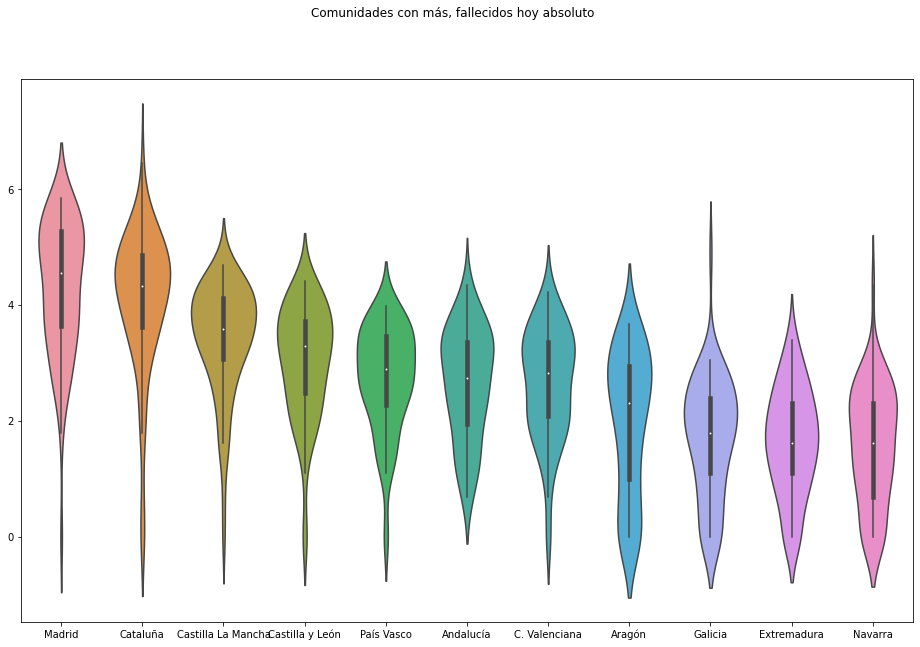

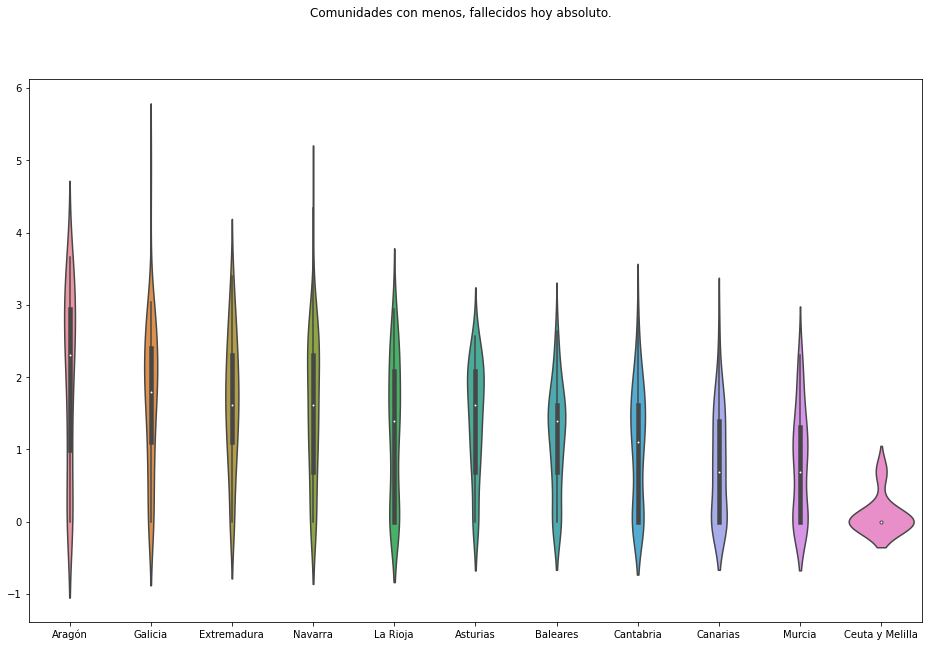

In [4]:
import numpy as np 
import seaborn as sns

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Single_Dimension(dimension ):
    df = pd.DataFrame()
    df_tmp = pd.DataFrame()
    array = []
    #
    for ca in COMUNIDADES:
        df_tmp = Loading_data.Get_Comunidad(ca)
        new = df_tmp[[dimension]].copy()
        new.rename(columns={dimension: ca}, inplace=True)
        array.append(new)
    #
    df =  pd.concat(array, axis=1)
    return df

def plot_violin(dimension):
    """ Muestra la distribucion logaritmica por comunidades, de una dimension"""
    df = Get_Single_Dimension(dimension) 
    # Ordenamos comunidades 
    s = df.sum()
    df = df[s.sort_values(ascending=False).index[:]]

    # Pasamos a logaritmo
    df2 = np.log(df)
    df2.replace(-np.inf,  np.nan, inplace=True)
    display(HTML("<h2>Comparativa de distribucion de '" +dimension+ "', en cada CC.AA </h2>"))
    display(HTML("Distribuciones convertidas a logaritmos neperianos, para facilitar la comparación."))

    # primer grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con más, " + dimension.lower())
    sns.violinplot(data=df2.iloc[:,:-7])

    #segundo grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con menos, " + dimension.lower()+".")
    sns.violinplot(data=df2.iloc[:,7:])
    return df

dimension = 'Fallecidos hoy absoluto'
df = plot_violin(dimension)


In [5]:
df

,Madrid,Cataluña,Castilla La Mancha,Castilla y León,País Vasco,Andalucía,C. Valenciana,Aragón,Galicia,Extremadura,Navarra,La Rioja,Asturias,Baleares,Cantabria,Canarias,Murcia,Ceuta y Melilla
Fecha,,,,,,,,,,,,,,,,,,
2020-05-25,-291,-1126,-152,-48,-70,-57,-62,-32,-6,0,-19,0,-20,-11,-7,-7,-10,2
2020-05-24,21,38,6,0,0,2,3,0,3,-1,0,1,1,0,0,0,0,-2
2020-05-23,12,7,5,0,7,12,1,0,1,1,1,1,0,0,0,2,0,0
2020-05-22,13,635,10,1,4,2,6,10,1,1,2,2,0,1,0,0,0,0
2020-05-21,19,0,6,0,3,4,5,5,1,1,3,1,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11,10,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2020-03-10,13,2,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0
2020-03-09,6,1,0,0,5,0,0,0,0,0,0,-1,0,0,0,0,0,0


In [6]:


import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Comparar_Dos_Dimensiones(Atributos, media_movil=False, add_LR=False ):
    """ Compara dos dimensiones de atributos, Ma indica si hacerlo con la media movil"""
    
    df = Get_Dimensions_All_CCAA(Atributos,media_movil )
    df = df.sort_values(by=[df.columns[1],df.columns[2]])
    plt = Print_Two_Cordinates_CCAA(df, add_LR)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.set_index('Lugar').to_html(index=True)))
    return 

  

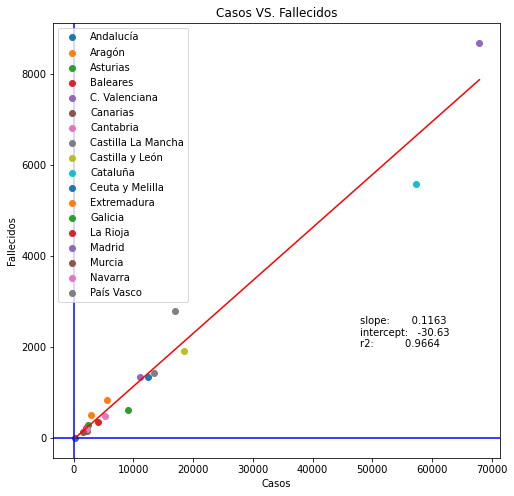

Total: Casos 235400
Total: Fallecidos 26834


,Casos,Fallecidos
Lugar,,
Ceuta y Melilla,245,6
Murcia,1573,139
Baleares,2035,211
Cantabria,2283,202
Canarias,2317,150
Asturias,2380,288
Extremadura,2952,506
La Rioja,4041,358
Navarra,5195,490


In [7]:
Insertar_Enlace("Comparativa_Casos_Fallecidos")
Comparar_Dos_Dimensiones(['Casos', 'Fallecidos'],add_LR=True )  


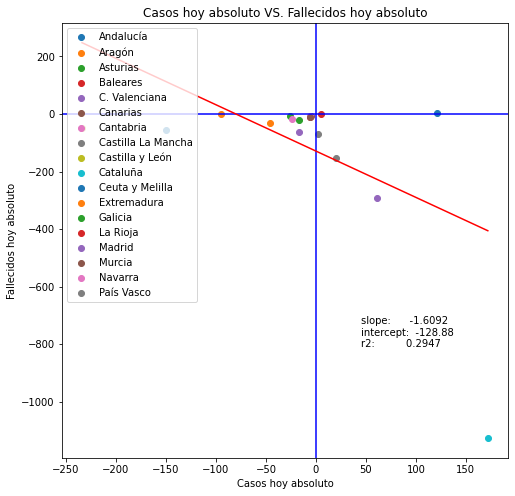

Total: Casos hoy absoluto -251
Total: Fallecidos hoy absoluto -1916


,Casos hoy absoluto,Fallecidos hoy absoluto
Lugar,,
Castilla y León,-234,-48
Andalucía,-150,-57
Extremadura,-95,0
Aragón,-46,-32
Galicia,-26,-6
Navarra,-24,-19
C. Valenciana,-17,-62
Asturias,-17,-20
Baleares,-6,-11


In [8]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Hoy")

Comparar_Dos_Dimensiones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'],add_LR=True )   

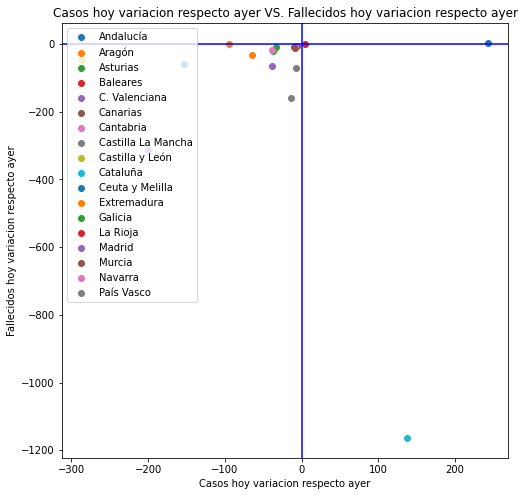

Total: Casos hoy variacion respecto ayer -612
Total: Fallecidos hoy variacion respecto ayer -1988


,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
Lugar,,
Castilla y León,-286,-48
Madrid,-200,-312
Andalucía,-153,-59
Extremadura,-94,1
Aragón,-65,-32
C. Valenciana,-39,-65
Navarra,-38,-19
Asturias,-37,-21
Galicia,-33,-9


In [9]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Variacion_Diaria")

Comparar_Dos_Dimensiones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])

In [10]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension,include_nation=False):
    def Do_Stuff_to_DF(df):
        df = df.sort_values(by='Fecha')
        # df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]
        return df
        
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = Do_Stuff_to_DF(df)
        dimension_df[ca] = df[Dimension]
    if include_nation:
        df = Loading_data.Get_Nacion()
        df = Do_Stuff_to_DF(df)
        dimension_df['TOTAL'] = df[Dimension]
        
    return dimension_df 


In [11]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import pandas as pd

import numpy as np


def compare_charts_median(Dimension,df): 
    short_df = df.tail(1)
    short_df = short_df.T
    short_df = short_df.sort_values(by=(short_df.columns[0]))
    short_df.columns = [Dimension]

    #mean_y = short_df.median(axis=1)[0]
    #mean_y= df.tail(1).T.median().values[0]
    median_y= df.tail(1).T.drop(axis=0,labels=(['TOTAL'] if 'TOTAL' in short_df.index else [])).median().values[0]
    x = short_df.index
    y = short_df[Dimension]

    plt.figure(figsize = (10, 5))
    plt.scatter(x, y, c= "red", alpha = 0.5)
    plt.title(Dimension + " by region")
    color = 'blue'
    plt.xticks(rotation=90)
    plt.axhline(median_y, c = color, alpha = 0.5, lw = 1)
    plt.annotate('Median ' + Dimension+  ' is {}'.format(round(median_y, 2)),
            xy=(8.5, median_y),
            xycoords='data',
            xytext=(-50, 50), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = "k", alpha = 0.5),
            color = color)
    return

def compare_charts_time(Dimension,df):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

    fig.suptitle('Comparativa de: '+Dimension, fontsize=20)
    plt.show()
    return 

def Report_Location(Dimension,include_nation=False):
    # Ger Data
    df = Get_Dimension_CCAA(Dimension,include_nation)
    # Compare chart
    compare_charts_time(Dimension,df)
    # Compare median chart
    compare_charts_median(Dimension,df)
    
    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 

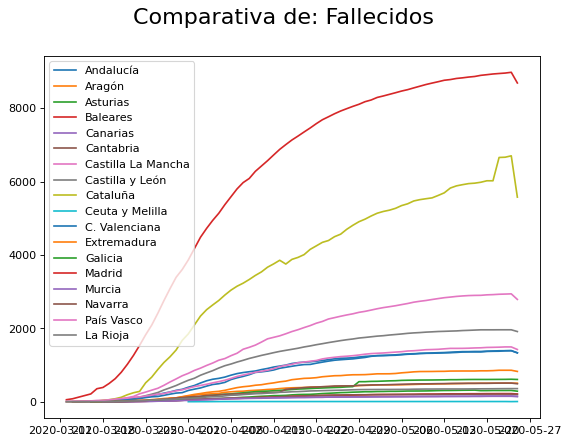

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
2020-03-16,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
2020-03-17,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
2020-03-18,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
2020-03-19,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
2020-03-20,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
2020-03-21,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
2020-03-22,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18


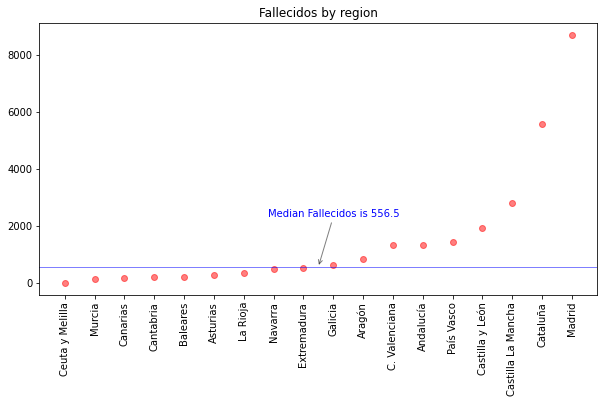

In [12]:
Insertar_Enlace("Comunidades_Fallecidos")
Report_Location("Fallecidos")

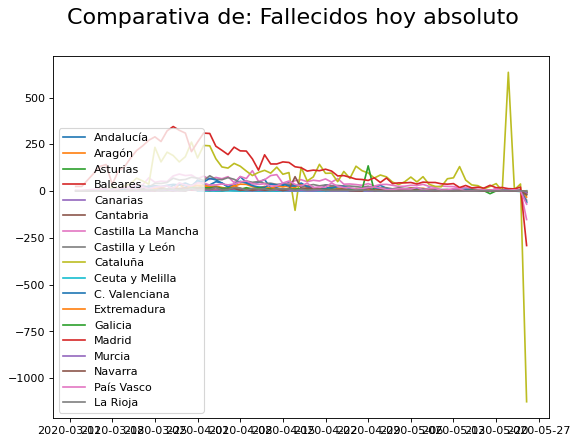

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
2020-03-16,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
2020-03-17,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
2020-03-18,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
2020-03-19,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
2020-03-20,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
2020-03-21,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
2020-03-22,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3


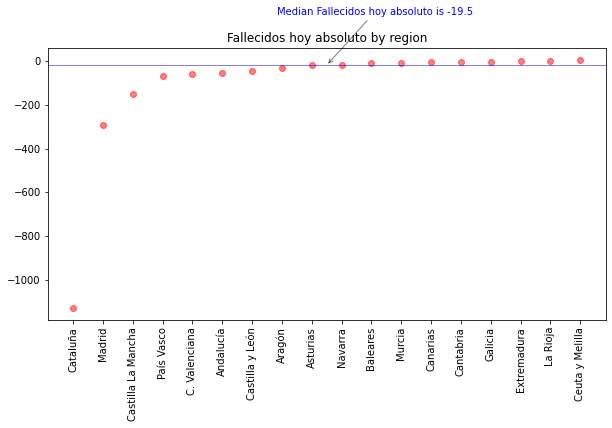

In [13]:
Insertar_Enlace("Comunidades_Fallecidos_Hoy")

Report_Location("Fallecidos hoy absoluto") 

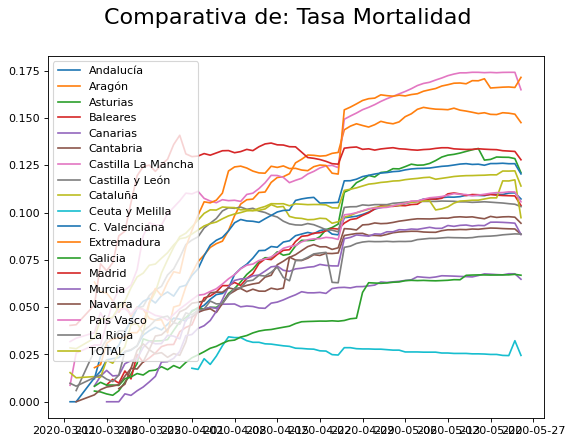

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja,TOTAL
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-12,0.000000,NaN,NaN,NaN,NaN,NaN,0.008696,NaN,0.015385,NaN,NaN,NaN,NaN,0.040346,NaN,NaN,0.031792,0.009756,0.028475
2020-03-13,0.000000,NaN,NaN,NaN,NaN,NaN,0.025773,0.005917,0.012658,NaN,NaN,NaN,NaN,0.040704,NaN,0.000000,0.033573,0.008230,0.028035
2020-03-16,0.012635,0.063218,0.005650,NaN,0.008403,NaN,0.029982,0.026946,0.013289,NaN,0.012225,0.018018,0.008163,0.051140,NaN,0.003650,0.036508,0.012821,0.033620
2020-03-17,0.016105,0.057971,0.005181,NaN,0.013514,NaN,0.029982,0.027842,0.012912,NaN,0.024030,0.019608,0.010274,0.072880,NaN,0.006390,0.047059,0.014085,0.043926
2020-03-18,0.022119,0.057522,0.004132,0.008929,0.016575,NaN,0.041481,0.032934,0.021972,NaN,0.030303,0.030928,0.008798,0.069186,0.000000,0.007772,0.041110,0.011933,0.043599
2020-03-19,0.022817,0.053381,0.003425,0.011834,0.013636,NaN,0.052434,0.033410,0.020355,NaN,0.026059,0.033195,0.008830,0.073484,0.000000,0.008299,0.044538,0.010684,0.044731
2020-03-20,0.023310,0.047222,0.005814,0.009852,0.013937,0.006944,0.059387,0.037489,0.025076,NaN,0.029864,0.033670,0.008651,0.087648,0.000000,0.009025,0.048464,0.014085,0.050150
2020-03-21,0.026403,0.051887,0.010288,0.016260,0.020115,0.009302,0.059030,0.037517,0.029027,NaN,0.036684,0.033898,0.012179,0.090124,0.004167,0.013554,0.049275,0.026596,0.053197
2020-03-22,0.027246,0.045113,0.014679,0.012085,0.021739,0.017730,0.061572,0.042431,0.040604,NaN,0.043017,0.036458,0.013115,0.105236,0.003378,0.017632,0.046257,0.027523,0.060199


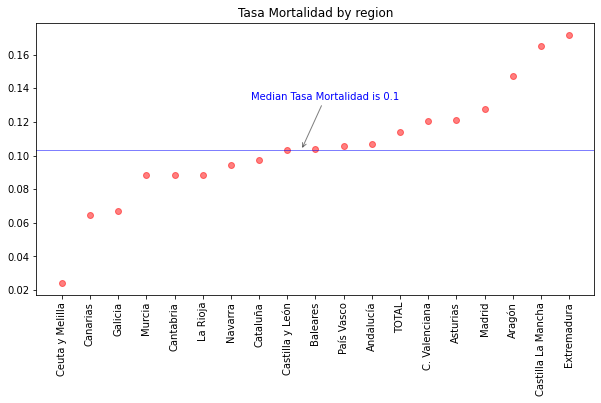

In [14]:
Insertar_Enlace("Comunidades_Mortalidad")

Report_Location("Tasa Mortalidad",True)

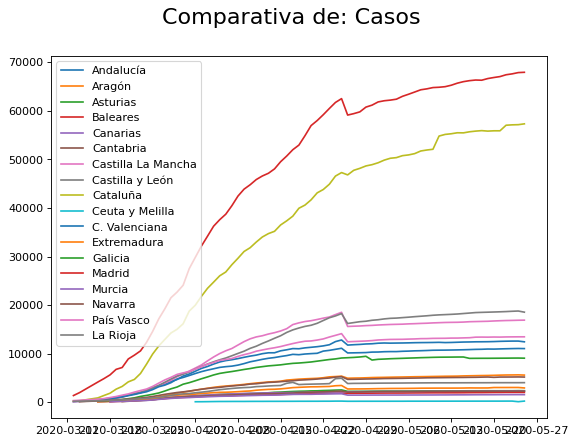

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
2020-03-13,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
2020-03-16,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
2020-03-17,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
2020-03-18,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
2020-03-19,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
2020-03-20,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
2020-03-21,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
2020-03-22,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654


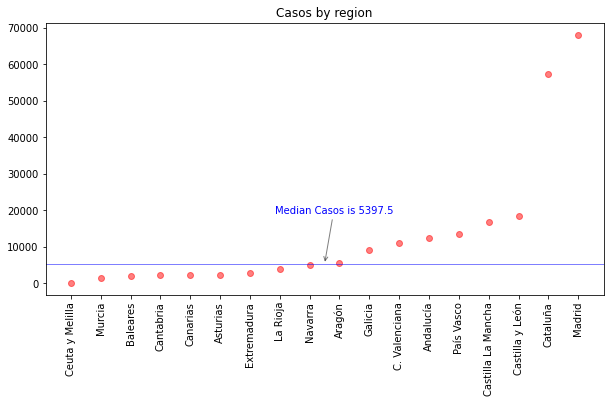

In [15]:
Insertar_Enlace("Comunidades_Casos")

Report_Location("Casos") 

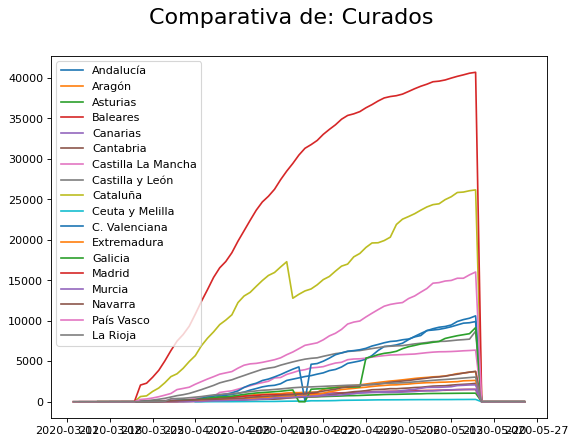

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0
2020-03-16,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-17,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-18,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-19,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-21,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-22,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0


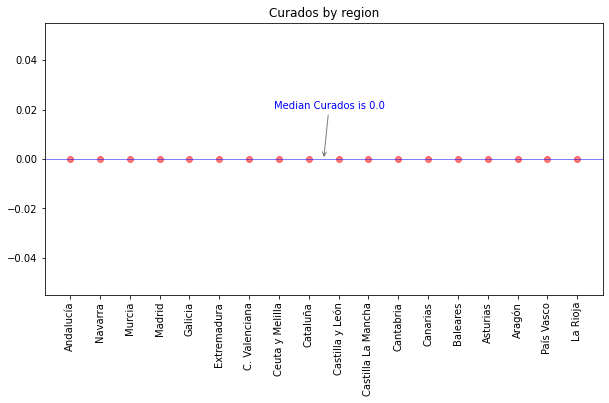

In [16]:
Insertar_Enlace("Curados")

Report_Location("Curados")

## ¿Hemos alcanzado el pico de la curva?


### Casos totales españa, evolucion


,Total Fallecidos,Total Fallecidos hoy absoluto,MA Total Fallecidos hoy absoluto,Variacion MA Total Fallecidos hoy absoluto
Fecha,,,,
2020-03-12,74,NaN,NaN,NaN
2020-03-13,107,33.0,NaN,NaN
2020-03-16,308,201.0,NaN,NaN
2020-03-17,490,182.0,NaN,NaN
2020-03-18,597,107.0,130.75,NaN
...,...,...,...,...
2020-05-21,27940,52.0,72.50,-8.75
2020-05-22,28628,688.0,229.75,157.25
2020-05-23,28678,50.0,225.00,-4.75


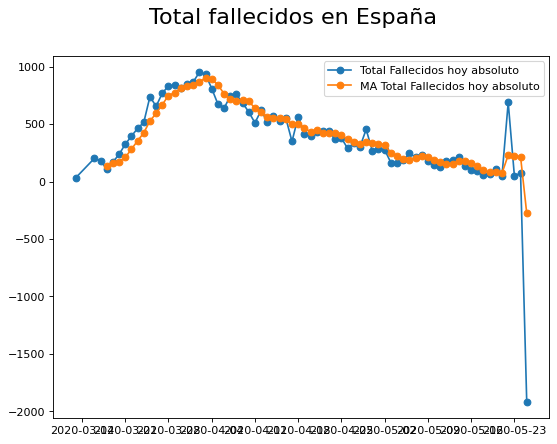

In [17]:
# Casos totales españa, evolucion
import Loading_data 

MOVING_AVERAGE_WINDOW=4

def get_fallecidos_nacion(window_size=MOVING_AVERAGE_WINDOW):
    Dimension = 'Fallecidos'
    
    Insertar_Enlace("Pico_España")

    df = Get_Dimension_CCAA(Dimension)

    df['Total Fallecidos'] = df.sum(axis=1)
    df['Total Fallecidos']

    CONVERT_INT_COLUMNS = ['Total Fallecidos']
    for column in CONVERT_INT_COLUMNS :
        df[column] = df[column].fillna(0)
        df[column] = df[column].astype(np.int64)

    df['Total Fallecidos hoy absoluto'] = df['Total Fallecidos'] - df['Total Fallecidos'].shift(1)
    df['MA Total Fallecidos hoy absoluto'] = df['Total Fallecidos hoy absoluto'].rolling(window=window_size).mean()

    df['Variacion MA Total Fallecidos hoy absoluto'] = df['MA Total Fallecidos hoy absoluto'] - df['MA Total Fallecidos hoy absoluto'].shift(1)
    return df

df = get_fallecidos_nacion()
df_plt = df[['Total Fallecidos hoy absoluto','MA Total Fallecidos hoy absoluto']]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(df_plt, marker='o') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.legend(df_plt.columns)
fig.suptitle( "Total fallecidos en España", fontsize=20)

df[['Total Fallecidos',
    'Total Fallecidos hoy absoluto',
    'MA Total Fallecidos hoy absoluto',
    'Variacion MA Total Fallecidos hoy absoluto']]



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-13,29.872539,0.000000,199.230877,29.872539,29.872539,47.941790,47.941790,47.941790,47.941790,47.941790,47.941790,0.0,0.0,0.0,77.814329
1,2020-03-16,166.756154,1.929171,254.516421,166.756154,166.756154,-42.831135,-42.831135,-42.831135,-42.831135,-42.831135,-42.831135,0.0,0.0,0.0,123.925019
2,2020-03-17,212.384026,84.125856,319.141199,212.384026,212.384026,-9.987408,-9.987408,-9.987408,-9.987408,-9.987408,-9.987408,0.0,0.0,0.0,202.396617
3,2020-03-18,258.011897,160.675744,408.347276,258.011897,258.011897,31.855342,31.855342,31.855342,31.855342,31.855342,31.855342,0.0,0.0,0.0,289.867239
4,2020-03-19,303.639769,190.998807,431.360094,303.639769,303.639769,11.598253,11.598253,11.598253,11.598253,11.598253,11.598253,0.0,0.0,0.0,315.238022
5,2020-03-20,349.267640,267.580117,517.888107,349.267640,349.267640,47.941790,47.941790,47.941790,47.941790,47.941790,47.941790,0.0,0.0,0.0,397.209430
6,2020-03-21,394.895512,267.606130,515.571553,394.895512,394.895512,-3.050960,-3.050960,-3.050960,-3.050960,-3.050960,-3.050960,0.0,0.0,0.0,391.844552
7,2020-03-22,440.523383,277.138366,526.015291,440.523383,440.523383,-35.525882,-35.525882,-35.525882,-35.525882,-35.525882,-35.525882,0.0,0.0,0.0,404.997502
8,2020-03-23,486.151255,315.668344,559.925564,486.151255,486.151255,-42.831135,-42.831135,-42.831135,-42.831135,-42.831135,-42.831135,0.0,0.0,0.0,443.320120
9,2020-03-24,531.779127,395.448590,637.178994,531.779127,531.779127,-9.987408,-9.987408,-9.987408,-9.987408,-9.987408,-9.987408,0.0,0.0,0.0,521.791718


Prediccion total para Total Fallecidos hoy absoluto : 28827.093265517233


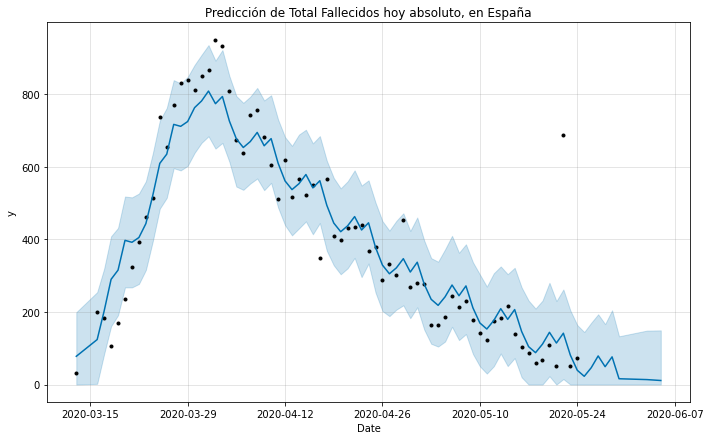

In [18]:
import fbprophet
def Get_Prediction_Nacion(df,dimension,location='España' , link=None) :
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()
    df.columns = ['ds','y']


    df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    df_prophet.fit(df)

    # Make a future dataframe for 2 years
    df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
    # Make predictions
    df_forecast = df_prophet.predict(df_forecast)
    df_forecast

    df_forecast = df_forecast[df_forecast["yhat"] >= 0]
    df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0
    
    if link is not None:
        Insertar_Enlace(link)

    df_prophet.plot(df_forecast, xlabel = 'Date' )
    plt.title('Predicción de ' + dimension + ", en " + location )

    suma = df_forecast.trend.sum()
    display(HTML(pd.DataFrame(df_forecast).to_html()))

    print ("Prediccion total para " + dimension + " : " + str(suma) )
    return df_forecast
    
    
Insertar_Enlace("Prediccion_Fallecidos_España")
    
prediccion = Get_Prediction_Nacion( df = get_fallecidos_nacion(), 
                                   dimension = 'Total Fallecidos hoy absoluto')

In [19]:
def Get_Predictions_Compare(df,dimension,location='España' , link=None) :
    if link is not None:
        Insertar_Enlace(link)


    display(HTML("<h2>Comparativa de predicciones, hoy contra días pasados, " +dimension+ " en " +  location+ "</h2>"))

        
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()

    df.columns = ['ds','y']
    
    df_original = df.copy()

    
    results = pd.DataFrame()
    array_results_temp = []
    for i in range(4):
        
        if i >= 1 : df = df.iloc[1:]
    
        fecha=max(df.ds)
        fecha_short = str(fecha)[:10]
        

        df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
        df_prophet.fit(df)

        # Make a future dataframe 
        df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
        # Make predictions
        df_forecast = df_prophet.predict(df_forecast)
        suma = df_forecast.yhat.sum()
            
        title_column = "Predicción con los datos de " + fecha_short
        df_forecast[title_column] = df_forecast.yhat
        
        array_results_temp.append(pd.DataFrame(df_forecast[['ds',title_column]]))


    df_1 = pd.merge(array_results_temp[0], array_results_temp[1], how ='outer', on ='ds') 
    df_2 = pd.merge(df_1                 , array_results_temp[2], how ='outer', on ='ds') 
    df_3 = pd.merge(df_2                 , array_results_temp[3], how ='outer', on ='ds') 
    df_4 = pd.merge(df_3                 , df_original          , how ='outer', on ='ds') 
    df_4['datos reales'] = df_4['y']
    del df_4['y']

        
    df_chart = df_4
    df_chart = df_chart.set_index('ds')
    df_chart = df_chart.head(70).tail(40)

    for c in df_chart.columns: 
        df_chart.loc[df_chart[c] < 0, c] = 0

    df_chart.drop(df_chart.loc[df_chart.sum(axis=1)==0].index, inplace=True)
    df_chart.drop(columns=df_chart.columns[df_chart.sum()==0], inplace=True)


    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df_chart) 
    plt.title("Predicciones en días anteriores Vs. Datos reales" + dimension +", en " + location )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=90)
    plt.legend(df_chart.columns)



    #print(df_chart)

    print("Las predicciones del total de "+ dimension+  " en " +  location+  ", cambian dia a dia")
    print(df_chart.sum(axis=0) )

    return df_chart



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en España, cambian dia a dia
Predicción con los datos de 2020-05-24    11691.123456
Predicción con los datos de 2020-05-23    11685.270568
Predicción con los datos de 2020-05-22    11708.725567
Predicción con los datos de 2020-05-21    10685.749699
datos reales                              11189.000000
dtype: float64


,Predicción con los datos de 2020-05-24,Predicción con los datos de 2020-05-23,Predicción con los datos de 2020-05-22,Predicción con los datos de 2020-05-21,datos reales
ds,,,,,
2020-04-14,553.261868,557.252939,555.719328,562.340233,567.0
2020-04-15,578.539137,582.593172,580.770881,585.237524,523.0
2020-04-16,541.716566,545.833563,543.722569,545.411526,551.0
2020-04-17,561.494621,566.253376,564.226267,507.758126,348.0
2020-04-18,493.936390,499.215127,501.429769,489.856500,565.0
2020-04-19,444.895986,448.031621,445.782938,430.999319,410.0
2020-04-20,421.025265,428.506902,426.228375,411.715197,399.0
2020-04-21,437.303523,445.654578,442.279966,425.740005,430.0
2020-04-22,462.587778,470.997173,467.331825,448.653421,435.0


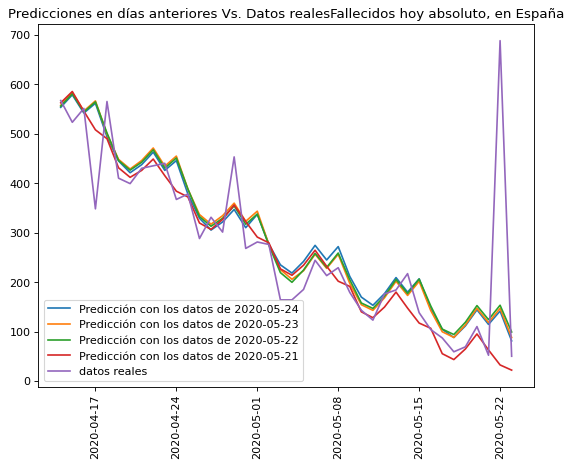

In [20]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'España'

link="Prediccion_Fallecidos_hoy_absoluto_España"


df = get_fallecidos_nacion()[['Total Fallecidos hoy absoluto']] 
df.columns = [ 'Fallecidos hoy absoluto' ]
df.sort_index(inplace=True,ascending=False)

prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

In [21]:
MOVING_AVERAGE_WINDOW = 4
def report_single_location_single_dimension(location,dimension,window_size=MOVING_AVERAGE_WINDOW):
    
    Dimension = 'Fallecidos'
    labelMa = f'Moving Average ({window_size}) {dimension}'

    df = pd.DataFrame()
    df[dimension] = Get_Dimension_CCAA(dimension)[location]
    df[labelMa] = df[dimension].rolling(window=window_size).mean()

    display(HTML("<h2>Analisis de ''" + dimension +"'', en " + location + "</h2>"))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df, marker='o') 
    plt.title("Gráfico de " + dimension +", en " + location)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


    plt.legend(df.columns)
    fig.suptitle( dimension + ' in ' + location, fontsize=20)

    display(HTML(pd.DataFrame(df).to_html()))
    return  


### Casos totales españa, evolucion


,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,25,NaN
2020-03-13,25,NaN
2020-03-16,132,NaN
2020-03-17,142,81.00
2020-03-18,35,83.50
2020-03-19,108,104.25
2020-03-20,130,103.75
2020-03-21,176,112.25
2020-03-22,217,157.75


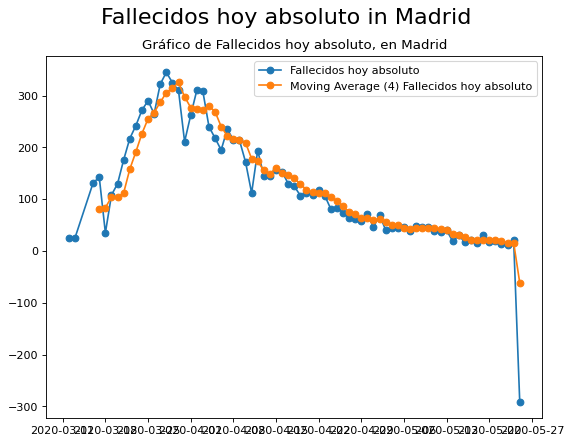

In [22]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Madrid")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension,4)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-09,2.076102,0.000000,37.958677,2.076102,2.076102,0.373621,0.373621,0.373621,0.373621,0.373621,0.373621,0.0,0.0,0.0,2.449723
2,2020-03-10,17.434441,0.000000,49.919646,17.434441,17.434441,-0.548281,-0.548281,-0.548281,-0.548281,-0.548281,-0.548281,0.0,0.0,0.0,16.886159
3,2020-03-11,32.792779,0.000000,63.169620,32.792779,32.792779,-6.106697,-6.106697,-6.106697,-6.106697,-6.106697,-6.106697,0.0,0.0,0.0,26.686083
4,2020-03-12,48.151118,16.108484,82.358979,48.151118,48.151118,0.879932,0.879932,0.879932,0.879932,0.879932,0.879932,0.0,0.0,0.0,49.031050
5,2020-03-13,63.509457,30.666230,99.394524,63.509457,63.509457,2.044200,2.044200,2.044200,2.044200,2.044200,2.044200,0.0,0.0,0.0,65.553657
6,2020-03-16,109.584474,74.878660,144.971132,109.584474,109.584474,0.373621,0.373621,0.373621,0.373621,0.373621,0.373621,0.0,0.0,0.0,109.958095
7,2020-03-17,124.942813,89.889125,159.589055,124.942813,124.942813,-0.548281,-0.548281,-0.548281,-0.548281,-0.548281,-0.548281,0.0,0.0,0.0,124.394532
8,2020-03-18,140.301152,97.668864,167.281395,140.301152,140.301152,-6.106697,-6.106697,-6.106697,-6.106697,-6.106697,-6.106697,0.0,0.0,0.0,134.194455
9,2020-03-19,155.659491,123.413818,192.754227,155.659491,155.659491,0.879932,0.879932,0.879932,0.879932,0.879932,0.879932,0.0,0.0,0.0,156.539423
10,2020-03-20,171.017830,139.067230,209.147742,171.017830,171.017830,2.044200,2.044200,2.044200,2.044200,2.044200,2.044200,0.0,0.0,0.0,173.062030


Prediccion total para Fallecidos hoy absoluto : 9021.233920525461


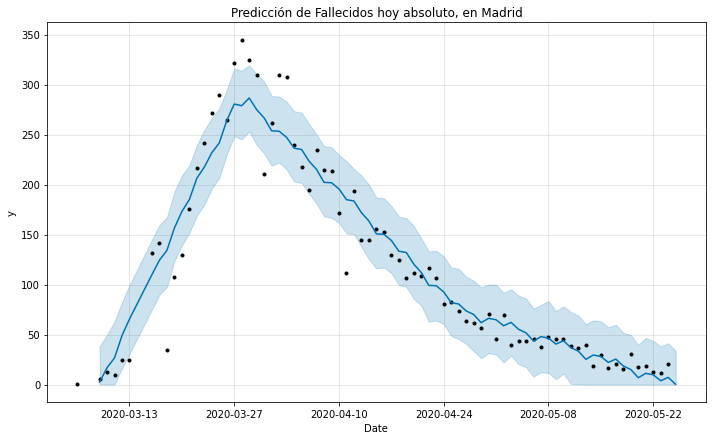

In [23]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

link="Prediccion_Fallecidos_hoy_absoluto_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Madrid, cambian dia a dia
Predicción con los datos de 2020-05-24    3504.067771
Predicción con los datos de 2020-05-23    3496.654179
Predicción con los datos de 2020-05-22    3495.348031
Predicción con los datos de 2020-05-21    3518.220285
datos reales                              3277.000000
dtype: float64


,Predicción con los datos de 2020-05-24,Predicción con los datos de 2020-05-23,Predicción con los datos de 2020-05-22,Predicción con los datos de 2020-05-21,datos reales
ds,,,,,
2020-04-09,201.871118,202.230638,204.102713,200.781273,214.0
2020-04-10,195.672429,196.023359,198.106717,195.672531,172.0
2020-04-11,184.952436,185.036751,185.964283,185.039701,112.0
2020-04-12,183.572375,181.596038,182.621428,183.488425,194.0
2020-04-13,171.913139,171.728286,172.442022,172.982919,145.0
2020-04-14,163.628440,163.603606,164.222118,164.361036,145.0
2020-04-15,150.707485,150.842875,151.367241,151.648971,156.0
2020-04-16,150.331574,150.472897,151.057798,151.481952,153.0
2020-04-17,144.133303,144.266012,145.063882,146.373944,130.0


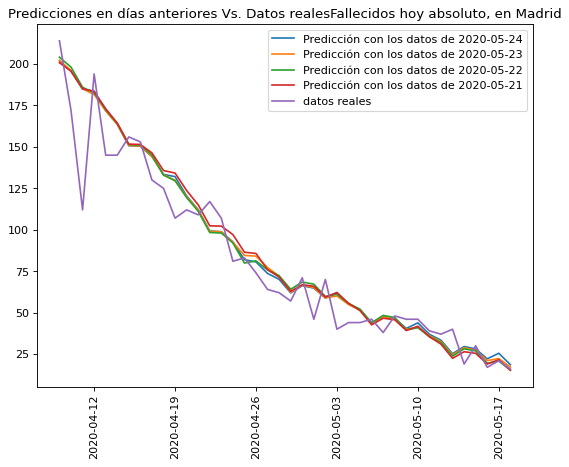

In [24]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_Madrid"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,0,NaN
2020-03-16,8,NaN
2020-03-17,6,3.75
2020-03-18,23,9.25
2020-03-19,14,12.75
2020-03-20,27,17.50
2020-03-21,40,26.00
2020-03-22,69,37.50


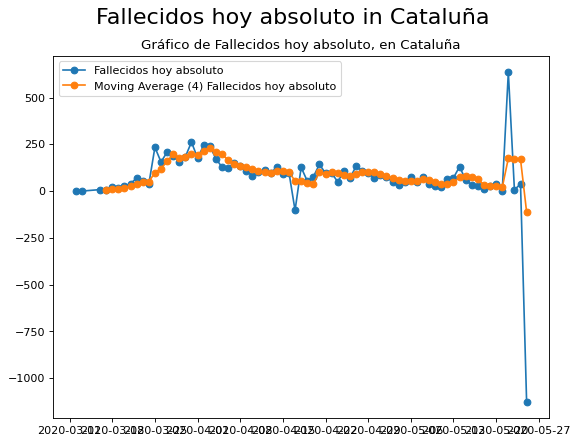

In [25]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Cataluña")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-09,31.238639,0.000000,99.066818,31.238639,31.238639,-25.272315,-25.272315,-25.272315,-25.272315,-25.272315,-25.272315,0.0,0.0,0.0,5.966324
1,2020-03-10,35.844973,0.000000,135.219984,35.844973,35.844973,-5.194245,-5.194245,-5.194245,-5.194245,-5.194245,-5.194245,0.0,0.0,0.0,30.650728
2,2020-03-12,45.057641,0.000000,152.288692,45.057641,45.057641,-0.261550,-0.261550,-0.261550,-0.261550,-0.261550,-0.261550,0.0,0.0,0.0,44.796091
3,2020-03-16,63.482977,0.000000,127.834975,63.482977,63.482977,-25.272315,-25.272315,-25.272315,-25.272315,-25.272315,-25.272315,0.0,0.0,0.0,38.210662
4,2020-03-17,68.089311,0.000000,164.751974,68.089311,68.089311,-5.194245,-5.194245,-5.194245,-5.194245,-5.194245,-5.194245,0.0,0.0,0.0,62.895066
5,2020-03-18,72.695645,0.000000,173.516187,72.695645,72.695645,3.794831,3.794831,3.794831,3.794831,3.794831,3.794831,0.0,0.0,0.0,76.490476
6,2020-03-19,77.301979,0.000000,174.192479,77.301979,77.301979,-0.261550,-0.261550,-0.261550,-0.261550,-0.261550,-0.261550,0.0,0.0,0.0,77.040428
7,2020-03-20,81.908312,52.461309,248.726807,81.908312,81.908312,64.769734,64.769734,64.769734,64.769734,64.769734,64.769734,0.0,0.0,0.0,146.678046
8,2020-03-21,86.514646,0.000000,171.156723,86.514646,86.514646,-10.931007,-10.931007,-10.931007,-10.931007,-10.931007,-10.931007,0.0,0.0,0.0,75.583640
9,2020-03-22,91.120980,0.000000,165.233198,91.120980,91.120980,-26.905449,-26.905449,-26.905449,-26.905449,-26.905449,-26.905449,0.0,0.0,0.0,64.215532


Prediccion total para Fallecidos hoy absoluto : 8732.638523240048


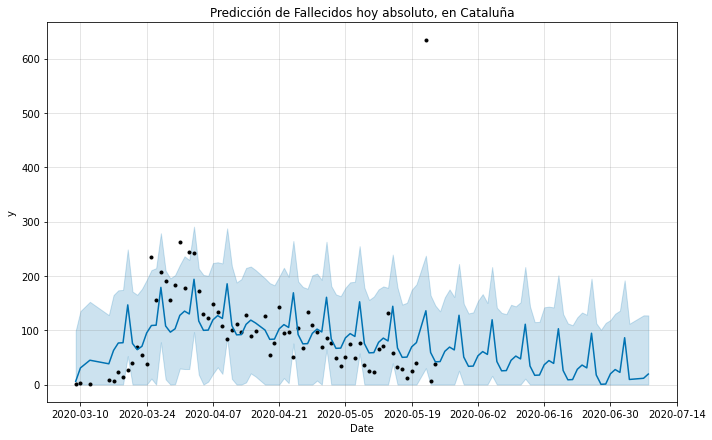

In [26]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'
link="Prediccion_Fallecidos_hoy_absoluto_Cataluña"


prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR)
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,NaN,NaN
2020-03-13,1.0,NaN
2020-03-16,8.0,NaN
2020-03-17,3.0,NaN
2020-03-18,10.0,5.50
2020-03-19,7.0,7.00
2020-03-20,14.0,8.50
2020-03-21,12.0,10.75
2020-03-22,19.0,13.00


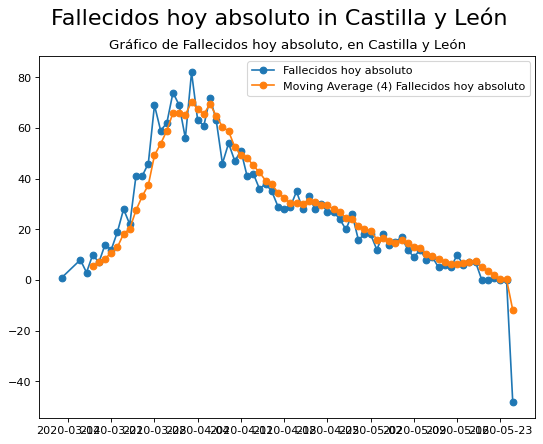

In [27]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla y León',dimension)

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CyL")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,2.669356,0.000000,12.510176,2.669356,2.669356,2.470962,2.470962,2.470962,2.470962,2.470962,2.470962,0.0,0.0,0.0,5.140318
2,2020-03-17,6.661468,0.000000,13.648465,6.661468,6.661468,-0.633078,-0.633078,-0.633078,-0.633078,-0.633078,-0.633078,0.0,0.0,0.0,6.028390
3,2020-03-18,10.653580,3.239936,17.071783,10.653580,10.653580,-0.171770,-0.171770,-0.171770,-0.171770,-0.171770,-0.171770,0.0,0.0,0.0,10.481810
4,2020-03-19,14.645692,5.406901,19.232001,14.645692,14.645692,-2.538127,-2.538127,-2.538127,-2.538127,-2.538127,-2.538127,0.0,0.0,0.0,12.107565
5,2020-03-20,18.637805,12.635845,27.094911,18.637805,18.637805,1.304538,1.304538,1.304538,1.304538,1.304538,1.304538,0.0,0.0,0.0,19.942343
6,2020-03-21,22.629917,15.738631,30.987340,22.629917,22.629917,0.853277,0.853277,0.853277,0.853277,0.853277,0.853277,0.0,0.0,0.0,23.483194
7,2020-03-22,26.622029,18.017726,32.501806,26.622029,26.622029,-1.285802,-1.285802,-1.285802,-1.285802,-1.285802,-1.285802,0.0,0.0,0.0,25.336227
8,2020-03-23,30.614141,25.671485,40.864695,30.614141,30.614141,2.470962,2.470962,2.470962,2.470962,2.470962,2.470962,0.0,0.0,0.0,33.085103
9,2020-03-24,34.606253,26.941881,41.124556,34.606253,34.606253,-0.633078,-0.633078,-0.633078,-0.633078,-0.633078,-0.633078,0.0,0.0,0.0,33.973175
10,2020-03-25,38.598366,31.104040,46.046360,38.598366,38.598366,-0.171770,-0.171770,-0.171770,-0.171770,-0.171770,-0.171770,0.0,0.0,0.0,38.426596


Prediccion total para Fallecidos hoy absoluto : 1965.86420917457


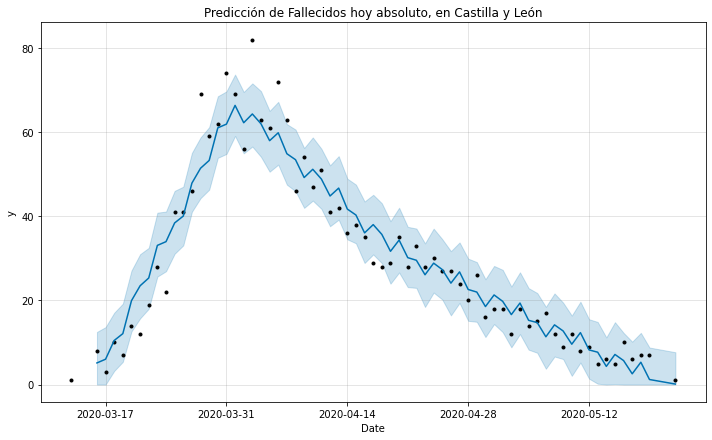

In [28]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla y León'
link="Prediccion_Fallecidos_hoy_absoluto_CyL"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,4,NaN
2020-03-16,12,NaN
2020-03-17,0,4.25
2020-03-18,11,6.75
2020-03-19,14,9.25
2020-03-20,20,11.25
2020-03-21,22,16.75
2020-03-22,28,21.00


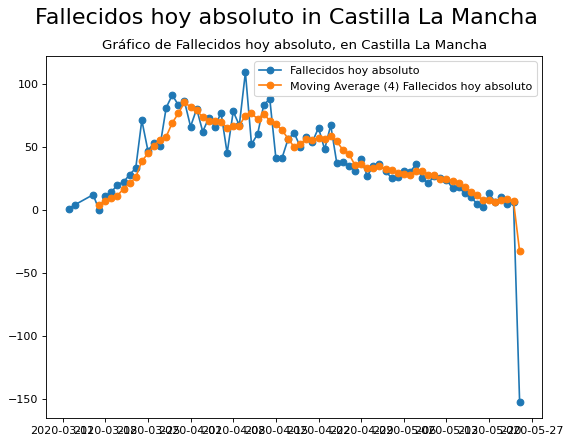

In [29]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla La Mancha',dimension)
Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CM")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-13,3.763682,0.000000,21.735557,3.763682,3.763682,3.960090,3.960090,3.960090,3.960090,3.960090,3.960090,0.0,0.0,0.0,7.723772
2,2020-03-16,15.580328,2.772011,31.136497,15.580328,15.580328,0.983787,0.983787,0.983787,0.983787,0.983787,0.983787,0.0,0.0,0.0,16.564115
3,2020-03-18,23.458091,8.834390,36.345007,23.458091,23.458091,-0.841984,-0.841984,-0.841984,-0.841984,-0.841984,-0.841984,0.0,0.0,0.0,22.616107
4,2020-03-19,27.396973,9.902357,37.968675,27.396973,27.396973,-3.488386,-3.488386,-3.488386,-3.488386,-3.488386,-3.488386,0.0,0.0,0.0,23.908587
5,2020-03-20,31.335855,20.806747,49.434872,31.335855,31.335855,3.960090,3.960090,3.960090,3.960090,3.960090,3.960090,0.0,0.0,0.0,35.295945
6,2020-03-21,35.274737,19.505851,47.509686,35.274737,35.274737,-1.379929,-1.379929,-1.379929,-1.379929,-1.379929,-1.379929,0.0,0.0,0.0,33.894808
7,2020-03-22,39.213619,23.938129,51.747217,39.213619,39.213619,-1.592254,-1.592254,-1.592254,-1.592254,-1.592254,-1.592254,0.0,0.0,0.0,37.621365
8,2020-03-23,43.152501,29.392455,58.619168,43.152501,43.152501,0.983787,0.983787,0.983787,0.983787,0.983787,0.983787,0.0,0.0,0.0,44.136288
9,2020-03-24,47.091382,35.124202,63.357560,47.091382,47.091382,2.358676,2.358676,2.358676,2.358676,2.358676,2.358676,0.0,0.0,0.0,49.450058
10,2020-03-25,51.030258,35.428362,64.554103,51.030258,51.030258,-0.841984,-0.841984,-0.841984,-0.841984,-0.841984,-0.841984,0.0,0.0,0.0,50.188273


Prediccion total para Fallecidos hoy absoluto : 2942.2217835543306


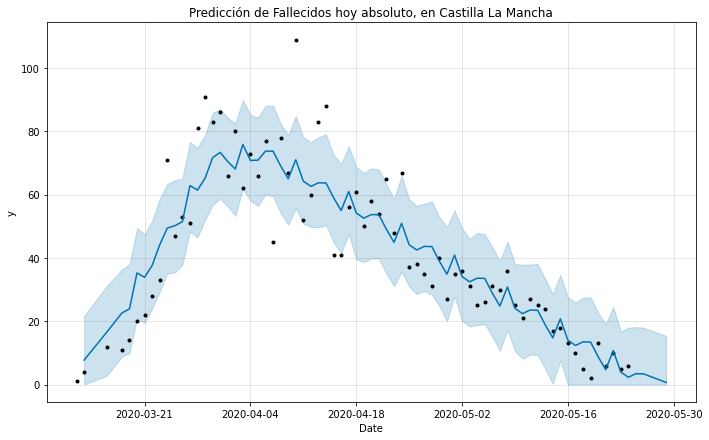

In [30]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Fallecidos_hoy_absoluto_CM"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Castilla La Mancha, cambian dia a dia
Predicción con los datos de 2020-05-24    1334.306411
Predicción con los datos de 2020-05-23    1338.276538
Predicción con los datos de 2020-05-22    1330.640507
Predicción con los datos de 2020-05-21    1331.069046
datos reales                              1308.000000
dtype: float64


,Predicción con los datos de 2020-05-24,Predicción con los datos de 2020-05-23,Predicción con los datos de 2020-05-22,Predicción con los datos de 2020-05-21,datos reales
ds,,,,,
2020-04-14,63.707229,65.215850,64.458739,64.615314,88.0
2020-04-15,59.072719,60.477493,59.647266,59.508409,41.0
2020-04-16,54.991743,56.312186,55.594574,55.277363,41.0
2020-04-17,61.005644,62.218689,61.635046,61.430809,56.0
2020-04-18,54.230188,55.440744,54.705032,54.844843,61.0
2020-04-19,52.582425,53.278765,52.798709,53.066110,50.0
2020-04-20,53.722275,54.858851,54.366811,54.600023,58.0
2020-04-21,53.660971,54.685427,54.131992,54.286827,54.0
2020-04-22,49.023643,49.946964,49.319771,49.179524,65.0


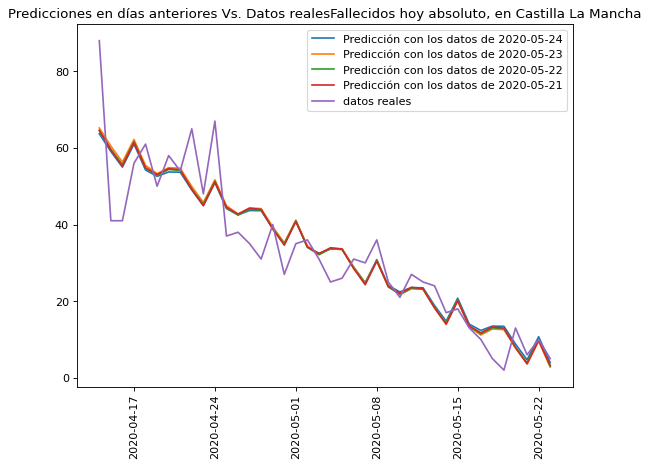

In [31]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_CM"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-21,8269.645318,0.000000,16164.525939,8269.645318,8269.645318,-1165.530792,-1165.530792,-1165.530792,-1165.530792,-1165.530792,-1165.530792,0.0,0.0,0.0,7104.114526
1,2020-03-22,8584.905592,0.000000,16147.052690,8584.905592,8584.905592,-1734.265824,-1734.265824,-1734.265824,-1734.265824,-1734.265824,-1734.265824,0.0,0.0,0.0,6850.639768
2,2020-03-23,8900.165866,673.407929,19601.938859,8900.165866,8900.165866,1024.169466,1024.169466,1024.169466,1024.169466,1024.169466,1024.169466,0.0,0.0,0.0,9924.335332
3,2020-03-24,9215.426139,1266.860850,20632.138984,9215.426139,9215.426139,1435.540812,1435.540812,1435.540812,1435.540812,1435.540812,1435.540812,0.0,0.0,0.0,10650.966952
4,2020-03-25,9530.686413,319.615072,19268.143392,9530.686413,9530.686413,748.646069,748.646069,748.646069,748.646069,748.646069,748.646069,0.0,0.0,0.0,10279.332481
5,2020-03-26,9845.946685,0.000000,19298.598390,9845.946685,9845.946685,163.322828,163.322828,163.322828,163.322828,163.322828,163.322828,0.0,0.0,0.0,10009.269513
6,2020-03-27,10161.206958,626.437186,19469.247018,10161.206958,10161.206958,-471.882559,-471.882559,-471.882559,-471.882559,-471.882559,-471.882559,0.0,0.0,0.0,9689.324399
7,2020-03-28,10476.467229,0.000000,18337.629750,10476.467229,10476.467229,-1165.530792,-1165.530792,-1165.530792,-1165.530792,-1165.530792,-1165.530792,0.0,0.0,0.0,9310.936438
8,2020-03-29,10791.727501,0.000000,18579.186641,10791.727501,10791.727501,-1734.265824,-1734.265824,-1734.265824,-1734.265824,-1734.265824,-1734.265824,0.0,0.0,0.0,9057.461677
9,2020-03-30,11106.987772,2585.696049,21796.727924,11106.987772,11106.987772,1024.169466,1024.169466,1024.169466,1024.169466,1024.169466,1024.169466,0.0,0.0,0.0,12131.157238


Prediccion total para Hospitalizados : 4812456.907073193


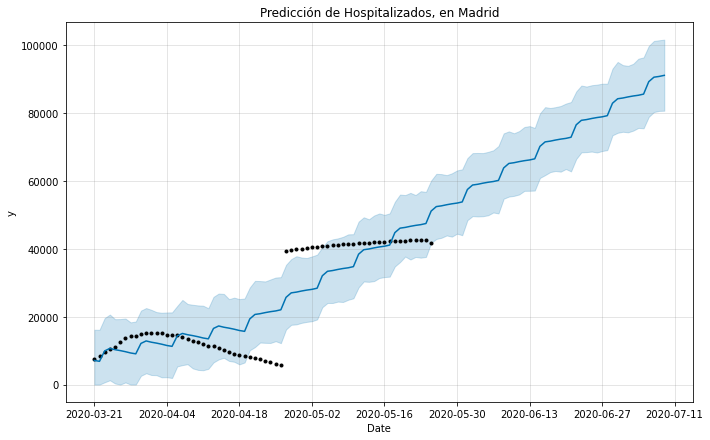

In [32]:
dimension = 'Hospitalizados'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Hospitalizados_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )

,Proporcion Curados hoy absoluto / Casos hoy absoluto,Moving Average (4) Proporcion Curados hoy absoluto / Casos hoy absoluto
Fecha,,
2020-03-12,0.000000,NaN
2020-03-13,0.000000,NaN
2020-03-16,0.000000,NaN
2020-03-17,0.000000,0.000000
2020-03-18,0.000000,0.000000
2020-03-19,0.000000,0.000000
2020-03-20,0.000000,0.000000
2020-03-21,0.000000,0.000000
2020-03-22,0.000000,0.000000


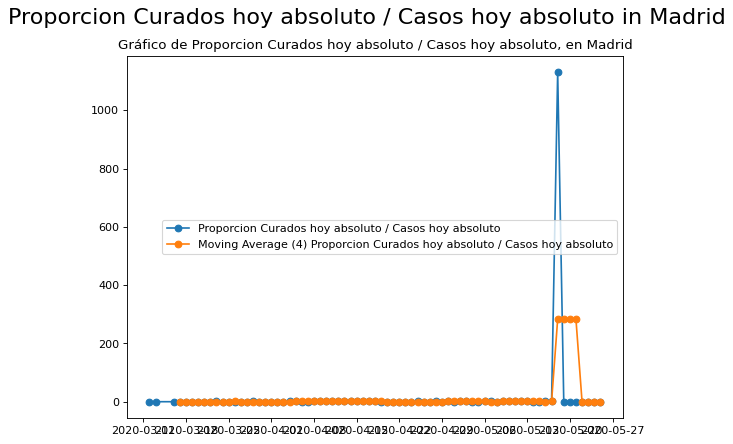

In [33]:
dimension = 'Proporcion Curados hoy absoluto / Casos hoy absoluto'
report_single_location_single_dimension('Madrid',dimension)


# ¿ Son reales estas cifras ? 
 
 Según reportaje de el mundo :https://www.elmundo.es/madrid/2020/04/07/5e8c427d21efa0b1668b45d6.html
 
   Entre los días 15 y 31 de marzo fallecieron en Madrid capital, "por todas las causas", aunque la mayoría por coronavirus, 5.950 personas, cuando en 2019, en el mismo lapso, murieron 1.100 personas

In [34]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)

Insertar_Enlace("Reales")

comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

madrid_muertos_segun_sanidad = comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

display(HTML ("Madrid muertos segun, <b>sanidad</b>, segunda quincena de Marzo:  <b>" + str(madrid_muertos_segun_sanidad)+"</b>"))

##

madrid_muertos_segun_interior = 5950 - 1100


display(HTML ("Madrid muertos segun, <b>interior</b>, mismo intervalo: <b>" + str(madrid_muertos_segun_interior)+"</b>"))


porcentaje_error = (madrid_muertos_segun_interior - madrid_muertos_segun_sanidad) / madrid_muertos_segun_sanidad


display(HTML ("La diferencia porcentual entre los muertos de sanidad e interior es de  <b>" + str(porcentaje_error) + "</b>") )

prediccion_muertos = comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error)



display(HTML ("El numero de <b>fallecidos en Madrid</b>, hasta ahora es de <b>" + str(comunidad['Fallecidos hoy absoluto'].sum()) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos)) + "</b> muertos" 
                                           ) )
Dimension = 'Fallecidos hoy absoluto'
df = Get_Dimension_CCAA(Dimension)

df['Total Fallecidos'] = df.sum(axis=1)

total_muertos_españa = int(df['Total Fallecidos'].sum())
prediccion_muertos_españa = total_muertos_españa* (1+porcentaje_error)

display(HTML ("El numero de <b>fallecidos en España</b>, hasta ahora es de <b>" + str(total_muertos_españa) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos_españa)) + "</b> muertos"
                                           ))

In [35]:
from datetime import datetime

COMUNIDAD_A_CONSIDERAR = 'Madrid'
#comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)


comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

3522

Text(0.5, 1.0, 'Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior')

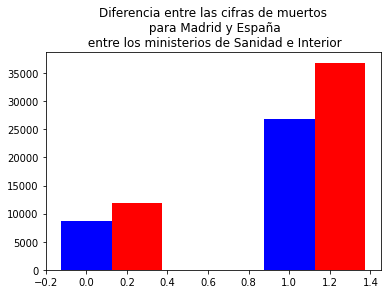

In [36]:
y = [comunidad['Fallecidos hoy absoluto'].sum(),total_muertos_españa]
z = [comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error), total_muertos_españa* (1+porcentaje_error)]

X = np.arange(2)

ax=plt.subplot(111)
plt.bar(X+0, y,color = 'b', width = 0.25)
plt.bar(X+0.25, z,color = 'r', width = 0.25)


ax.set_title("Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior")
